
=== Frame: Foreign influence threat ===
⚠️ Skipping Yara vs coder1: only one value in the domain.
⚠️ Skipping Yara vs frozen: only one value in the domain.
⚠️ Skipping Yara vs simone: only one value in the domain.
⚠️ Skipping anne vs coder1: only one value in the domain.
⚠️ Skipping anne vs frozen: only one value in the domain.
⚠️ Skipping coder1 vs frozen: only one value in the domain.
⚠️ Skipping coder1 vs simone: only one value in the domain.
⚠️ Skipping frozen vs simone: only one value in the domain.
Pairwise Krippendorff's alpha:
  Anne vs Elisa: α = 0.000
  Anne vs Yara: α = -0.133
  Anne vs anne: α = -0.167
  Anne vs coder1: α = 0.000
  Anne vs frozen: α = 0.000
  Anne vs simone: α = 0.000
  Elisa vs Yara: α = 0.000
  Elisa vs anne: α = 0.000
  Elisa vs coder1: α = N/A
  Elisa vs frozen: α = 0.000
  Elisa vs simone: α = 0.000
  Yara vs anne: α = 0.000
  Yara vs coder1: α = N/A
  Yara vs frozen: α = N/A
  Yara vs simone: α = N/A
  anne vs coder1: α = N/A
  anne vs frozen: α = N/

/tmp/ipykernel_613731/3754104546.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=results_df_sorted, x="overall_alpha", y="frame", palette="viridis")


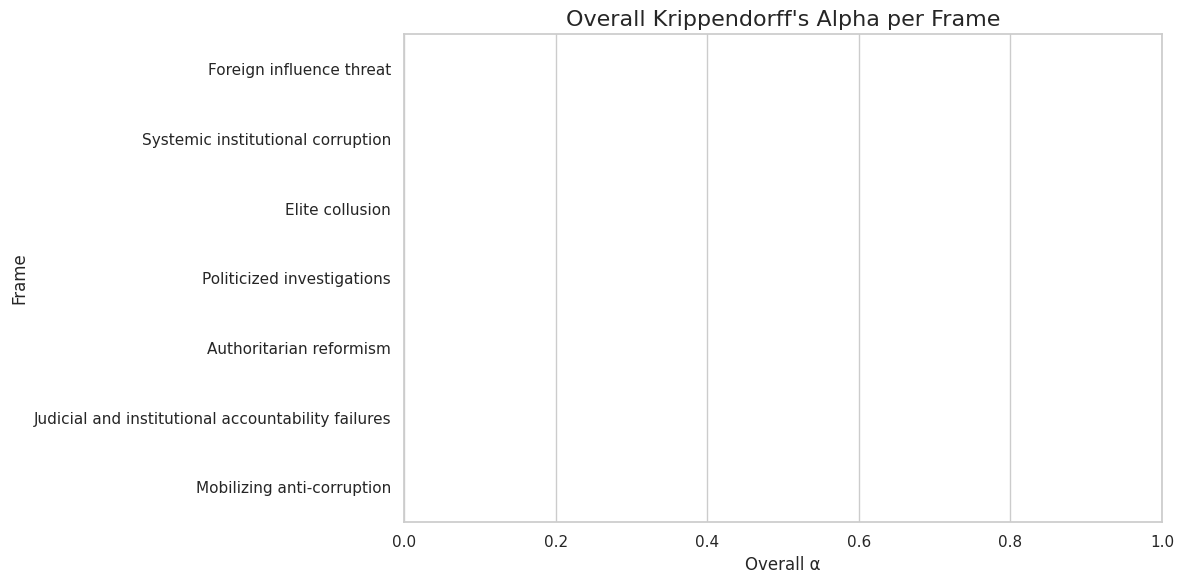

In [11]:
import os
import json
import pandas as pd
import numpy as np
import krippendorff
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# === CONFIG ===
SESSION_FOLDER = os.path.expanduser("~/webdav/ASCOR-FMG-5580-RESPOND-news-data (Projectfolder)/sessions/")
FRAME_LABELS = [
    "Foreign influence threat",
    "Systemic institutional corruption",
    "Elite collusion",
    "Politicized investigations",
    "Authoritarian reformism",
    "Judicial and institutional accountability failures",
    "Mobilizing anti-corruption"
]

# === HELPERS ===
def encode_label(val):
    return 1 if val == "Present" else 0 if val == "Not Present" else None

def load_all_annotations():
    data = []
    for filename in os.listdir(SESSION_FOLDER):
        if filename.endswith("_session.json"):
            user_id = filename.replace("_session.json", "")
            path = os.path.join(SESSION_FOLDER, filename)
            with open(path, "r", encoding="utf-8") as f:
                session_data = json.load(f)
                annotations = session_data.get("annotations", [])
                for ann in annotations:
                    ann["user_id"] = user_id
                    data.append(ann)
    return pd.DataFrame(data)

def prepare_matrix(df, frame_label):
    df = df[["user_id", "article_index", f"{frame_label}_present"]].copy()
    df[f"{frame_label}_present"] = df[f"{frame_label}_present"].map(encode_label)
    pivot = df.pivot(index="article_index", columns="user_id", values=f"{frame_label}_present")
    return pivot

def pairwise_krippendorff(matrix, coders):
    pairwise_results = {}
    for coder1, coder2 in combinations(coders, 2):
        pair_data = matrix[[coder1, coder2]].dropna()
        if pair_data.empty:
            alpha = np.nan
        else:
            reliability_data = pair_data.to_numpy().T
            unique_vals = np.unique(reliability_data[~np.isnan(reliability_data)])
            if len(unique_vals) < 2:
                alpha = np.nan
                print(f"⚠️ Skipping {coder1} vs {coder2}: only one value in the domain.")
            else:
                alpha = krippendorff.alpha(reliability_data=reliability_data, level_of_measurement='nominal')
        pairwise_results[(coder1, coder2)] = alpha
    return pairwise_results

# === MAIN FUNCTION ===
def compute_fine_grained_reliability():
    df = load_all_annotations()
    coders = df["user_id"].unique()
    frame_results = []

    for frame_label in FRAME_LABELS:
        print(f"\n=== Frame: {frame_label} ===")
        matrix = prepare_matrix(df, frame_label)
        coders_with_data = [c for c in coders if c in matrix.columns and matrix[c].notna().any()]
        
        if len(coders_with_data) < 2:
            print("Not enough coders with data to compute reliability.")
            frame_results.append({
                "frame": frame_label,
                "overall_alpha": np.nan,
                "avg_pairwise_alpha": np.nan,
                "num_disagreements": 0
            })
            continue

        # --- Pairwise Alphas ---
        pairwise_alphas = pairwise_krippendorff(matrix, coders_with_data)
        print("Pairwise Krippendorff's alpha:")
        for (c1, c2), alpha in sorted(pairwise_alphas.items()):
            print(f"  {c1} vs {c2}: α = {alpha:.3f}" if not np.isnan(alpha) else f"  {c1} vs {c2}: α = N/A")

        # --- Average per coder ---
        coder_scores = {coder: [] for coder in coders_with_data}
        for (c1, c2), alpha in pairwise_alphas.items():
            if not np.isnan(alpha):
                coder_scores[c1].append(alpha)
                coder_scores[c2].append(alpha)

        print("\nAverage pairwise alpha per coder:")
        for coder, scores in coder_scores.items():
            if scores:
                avg_alpha = np.mean(scores)
                print(f"  {coder}: {avg_alpha:.3f}")
            else:
                print(f"  {coder}: No pairwise alpha scores")

        # --- Overall Alpha ---
        complete_data = matrix.dropna(how='any')
        if complete_data.shape[0] > 0:
            reliability_data = complete_data.to_numpy().T
            unique_vals = np.unique(reliability_data[~np.isnan(reliability_data)])
            if len(unique_vals) < 2:
                overall_alpha = np.nan
                print("\n⚠️ Not enough variation in labels to compute overall alpha.")
            else:
                overall_alpha = krippendorff.alpha(
                    reliability_data=reliability_data,
                    level_of_measurement='nominal'
                )
                print(f"\n✅ Overall Krippendorff's alpha (all coders): α = {overall_alpha:.3f}")
        else:
            overall_alpha = np.nan
            print("\n⚠️ No article coded by all coders — can't compute overall alpha.")

        # --- Disagreement count ---
        disagreement_count = matrix.dropna(how='any').apply(lambda row: len(set(row)), axis=1)
        num_disagreements = (disagreement_count > 1).sum()
        print(f"{frame_label}: {num_disagreements} articles with coder disagreement")

        # --- Store for plotting ---
        frame_results.append({
            "frame": frame_label,
            "overall_alpha": overall_alpha,
            "avg_pairwise_alpha": np.mean([v for v in pairwise_alphas.values() if not np.isnan(v)]) if pairwise_alphas else np.nan,
            "num_disagreements": num_disagreements
        })

    return pd.DataFrame(frame_results)

# === PLOT FUNCTION ===
def plot_results(results_df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    results_df_sorted = results_df.sort_values("overall_alpha", ascending=False)

    ax = sns.barplot(data=results_df_sorted, x="overall_alpha", y="frame", palette="viridis")
    ax.set_title("Overall Krippendorff's Alpha per Frame", fontsize=16)
    ax.set_xlabel("Overall α", fontsize=12)
    ax.set_ylabel("Frame", fontsize=12)
    ax.set_xlim(0, 1)
    
    for i, val in enumerate(results_df_sorted["overall_alpha"]):
        if not np.isnan(val):
            ax.text(val + 0.02, i, f"{val:.2f}", va='center')

    plt.tight_layout()
    plt.show()

# === RUN ===
if __name__ == "__main__":
    results_df = compute_fine_grained_reliability()
    print("\n=== Summary DataFrame ===")
    print(results_df)
    plot_results(results_df)
